## Подготовка данных

Определим некоторые константы:

In [1]:
imsize = 32          #размер изображения
data_shape = (20, 13)  # количество изображений в одном датасете

path = 'D:/myprog/ai/lab4/processed' #путь к датасету

Определим функцию для загрузки датасета:

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_data(path, imsize, ds_h, ds_w):
    datasize = 0
    for folder in os.listdir(path):
        datasize += len(os.listdir(path + '/' + folder)) * ds_h * ds_w
    
    images = np.zeros((datasize, imsize, imsize), dtype=np.uint8)
    labels = np.zeros(datasize, dtype=np.uint8)
    
    i = 0
    for label, folder in enumerate(os.listdir(path)):
        for data_name in os.listdir(path + '/' + folder):
            data = plt.imread(path + '/' + folder + '/' + data_name)
            
            for j in range(ds_h):
                y = imsize * j
                for k in range(ds_w):
                    x = imsize * k
                    images[i] = data[y : y + imsize, x : x + imsize]
                    labels[i] = label
                    i += 1
    
    return images, labels

Теперь загрузим датасет и посмотрим на 4 случайных символа:

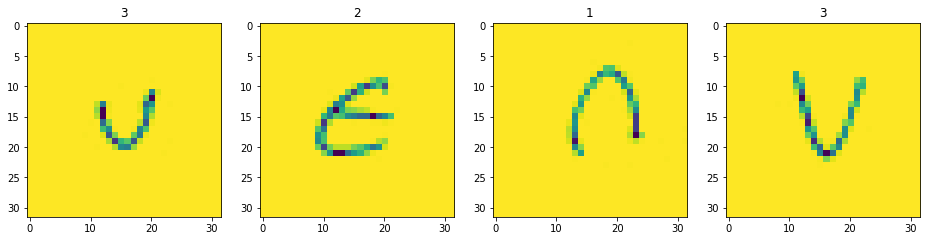

In [3]:
images, labels = load_data(path, imsize, *data_shape)

fig, subplots = plt.subplots(1, 4, figsize=(16,5))
indexes = np.random.choice(images.shape[0], 4)

for ax, i in zip(subplots, indexes):
    ax.imshow(images[i])
    ax.set_title('{}'.format(labels[i]))
plt.show()

Разделим данные на обучаущую и тестирующую выборки, приведем лейблы к one-hot encoding:

In [4]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)

#Нормализуем данные:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

num_classes = np.max(labels) + 1

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


Вся подготовительная работа закончена, можем перейти к непосредственному созданию и обучению нейронной сети.

## Полносвязная нейронная сеть

В полносвязной нейронной сети входной слой должен быть одномерным:

In [5]:
X_test = X_test.reshape(X_test.shape[0], imsize * imsize)
X_train = X_train.reshape(X_train.shape[0], imsize * imsize)

Для начала создадим нейронную сеть с одним скрытым слоем:

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(200, activation='relu', input_shape=(imsize * imsize,)))
model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


Так как классы сбалансированные, то мы можем использовать $accuracy$ для оценки качества модели:

In [7]:
model.compile(optimizer='Adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Здесь и далее будем использовать следующие параметры обучения. Так как датасет небольшой, то за одну итерацию будем обрабатывать 2 картинки.

In [8]:
batch_size = 2
epochs = 15

Обучим эту модель:

In [9]:
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))

Instructions for updating:
Use tf.cast instead.
Train on 1664 samples, validate on 416 samples
Epoch 1/15
1664/1664 [==============================] - 3s 2ms/step - loss: 1.4251 - acc: 0.2969 - val_loss: 1.3279 - val_acc: 0.2716
Epoch 2/15
1664/1664 [==============================] - 2s 1ms/step - loss: 1.2473 - acc: 0.4201 - val_loss: 1.0838 - val_acc: 0.4976
Epoch 3/15
1664/1664 [==============================] - 2s 2ms/step - loss: 1.0431 - acc: 0.5264 - val_loss: 0.9497 - val_acc: 0.5745
Epoch 4/15
1664/1664 [==============================] - 3s 2ms/step - loss: 0.9463 - acc: 0.5739 - val_loss: 0.9284 - val_acc: 0.5817
Epoch 5/15
1664/1664 [==============================] - 2s 1ms/step - loss: 0.8888 - acc: 0.5998 - val_loss: 0.8746 - val_acc: 0.6154
Epoch 6/15
1664/1664 [==============================] - 3s 2ms/step - loss: 0.8454 - acc: 0.6220 - val_loss: 0.8396 - val_acc: 0.6226
Epoch 7/15
1664/1664 [==============================] - 2s 1ms/step - loss: 0.8130 - acc: 0.6412 - va

Посмотрим на графики потерь и точности:

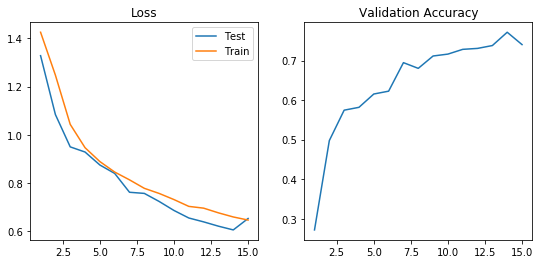

In [10]:
def plot_metrics(epochs, history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    
    ax1.plot(range(1, epochs + 1), history.history['val_loss'], label='Test')
    ax1.plot(range(1, epochs + 1), history.history['loss'], label='Train')
    ax1.set_title('Loss')
    ax1.legend()
    
    ax2.plot(range(1, epochs + 1), history.history['val_acc'])
    ax2.set_title('Validation Accuracy')
    
    plt.show()
    
plot_metrics(epochs, history)

Попробуем добавить еще один слой:

In [11]:
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(imsize * imsize,)))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='Adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))

Train on 1664 samples, validate on 416 samples
Epoch 1/15
1664/1664 [==============================] - 3s 2ms/step - loss: 1.4012 - acc: 0.2746 - val_loss: 1.4053 - val_acc: 0.2404
Epoch 2/15
1664/1664 [==============================] - 2s 1ms/step - loss: 1.2981 - acc: 0.3666 - val_loss: 1.1304 - val_acc: 0.5168
Epoch 3/15
1664/1664 [==============================] - 2s 992us/step - loss: 0.9508 - acc: 0.5619 - val_loss: 0.8036 - val_acc: 0.6755
Epoch 4/15
1664/1664 [==============================] - 2s 910us/step - loss: 0.7921 - acc: 0.6298 - val_loss: 0.6914 - val_acc: 0.6803
Epoch 5/15
1664/1664 [==============================] - 2s 945us/step - loss: 0.7170 - acc: 0.6683 - val_loss: 0.6584 - val_acc: 0.6923
Epoch 6/15
1664/1664 [==============================] - 2s 1ms/step - loss: 0.6631 - acc: 0.6971 - val_loss: 0.6574 - val_acc: 0.6875
Epoch 7/15
1664/1664 [==============================] - 2s 1ms/step - loss: 0.6069 - acc: 0.7338 - val_loss: 0.5883 - val_acc: 0.7668
Epoch 8/1

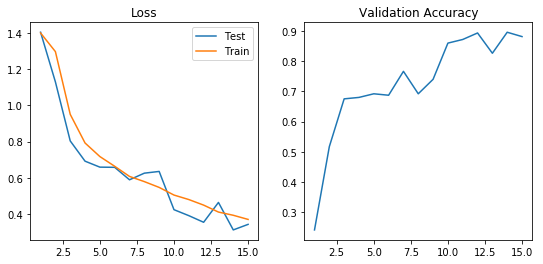

In [12]:
plot_metrics(epochs, history)

Точность с двумя скрытыми слоями около 90%, уже неплохой результат. Кстати, если во втором слое использовать $relu$ в качестве функции активации, то модель не сходится. 

## Cвёрточная нейронная сеть

В сверточной нейронной сети входной слой должен иметь размер $imsize \times imsize \times 1$:

In [13]:
X_test = X_test.reshape(X_test.shape[0], imsize, imsize, 1)
X_train = X_train.reshape(X_train.shape[0], imsize, imsize, 1)

Для начала построим сеть с одним сверточным слоем:

In [14]:
from keras.layers import Conv2D, Dropout, Flatten, MaxPooling2D

model = Sequential()

model.add(Conv2D(6, kernel_size=(4, 4), activation='relu', input_shape=(imsize, imsize, 1)))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='Adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))

Train on 1664 samples, validate on 416 samples
Epoch 1/15
1664/1664 [==============================] - 3s 2ms/step - loss: 0.5654 - acc: 0.7993 - val_loss: 0.1653 - val_acc: 0.9639
Epoch 2/15
1664/1664 [==============================] - 3s 2ms/step - loss: 0.1472 - acc: 0.9573 - val_loss: 0.0986 - val_acc: 0.9688
Epoch 3/15
1664/1664 [==============================] - 3s 2ms/step - loss: 0.0868 - acc: 0.9778 - val_loss: 0.0639 - val_acc: 0.9808
Epoch 4/15
1664/1664 [==============================] - 3s 2ms/step - loss: 0.0582 - acc: 0.9850 - val_loss: 0.0376 - val_acc: 0.9928
Epoch 5/15
1664/1664 [==============================] - 3s 2ms/step - loss: 0.0432 - acc: 0.9898 - val_loss: 0.0317 - val_acc: 0.9928
Epoch 6/15
1664/1664 [==============================] - 3s 2ms/step - loss: 0.0357 - acc: 0.9910 - val_loss: 0.0250 - val_acc: 0.9928
Epoch 7/15
1664/1664 [==============================] - 3s 2ms/step - loss: 0.0279 - acc: 0.9940 - val_loss: 0.0224 - val_acc: 0.9904
Epoch 8/15
1664

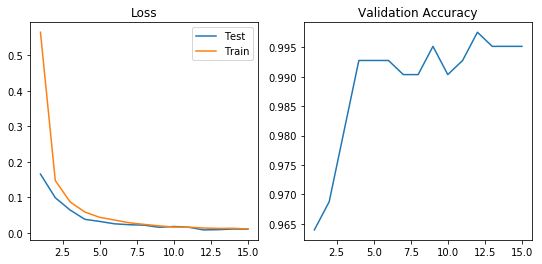

In [15]:
plot_metrics(epochs, history)

Точность уже близка к 100%, Посмотрим, какие символы модель не угадала:

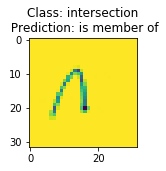

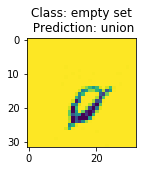

In [16]:
class_pred = [np.argmax(prediction) for prediction in model.predict(X_test)]
class_fact = y_test
classes = ['empty set', 'intersection', 'is member of', 'union']

for i, (fact, pred) in enumerate(zip(class_fact, class_pred)):
    if fact != pred:
        plt.figure(figsize=(2,2))
        plt.imshow(X_test[i].reshape(imsize, imsize))
        plt.title('Class: {}\n Prediction: {}'.format(classes[fact], classes[pred]))
        plt.show()

 Вряд ли получится улучшить такой результат, но попробуем добавить еще один сверточный слой перед слоем подвыборки.

In [17]:
model = Sequential()

model.add(Conv2D(4, kernel_size=(3, 3), activation='relu', input_shape=(imsize, imsize, 1)))
model.add(Conv2D(3, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='Adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))

Train on 1664 samples, validate on 416 samples
Epoch 1/15
1664/1664 [==============================] - 5s 3ms/step - loss: 0.6645 - acc: 0.7602 - val_loss: 0.2378 - val_acc: 0.9471
Epoch 2/15
1664/1664 [==============================] - 5s 3ms/step - loss: 0.2175 - acc: 0.9327 - val_loss: 0.1442 - val_acc: 0.9639
Epoch 3/15
1664/1664 [==============================] - 5s 3ms/step - loss: 0.1376 - acc: 0.9549 - val_loss: 0.0935 - val_acc: 0.9712
Epoch 4/15
1664/1664 [==============================] - 5s 3ms/step - loss: 0.0979 - acc: 0.9700 - val_loss: 0.1214 - val_acc: 0.9639
Epoch 5/15
1664/1664 [==============================] - 5s 3ms/step - loss: 0.0790 - acc: 0.9778 - val_loss: 0.0681 - val_acc: 0.9808
Epoch 6/15
1664/1664 [==============================] - 5s 3ms/step - loss: 0.0605 - acc: 0.9832 - val_loss: 0.0661 - val_acc: 0.9832
Epoch 7/15
1664/1664 [==============================] - 5s 3ms/step - loss: 0.0504 - acc: 0.9892 - val_loss: 0.0605 - val_acc: 0.9832
Epoch 8/15
1664

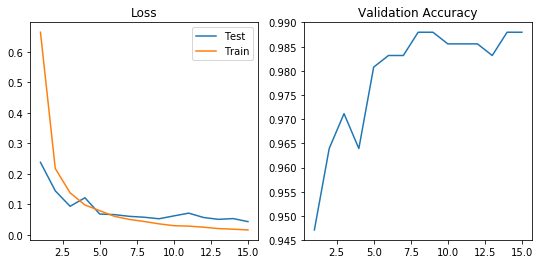

In [18]:
plot_metrics(epochs, history)

Точность модели с двумя сверточными слоями соизмерима с моделью с одним сверточным слоем, поэтому нет смысла усложнять и так нелохую сеть, здесь требуется более тонкая настройка.

Так же можно заметить, что в отличии от полносвязной нейронной сети сверточная нейронная сеть сходится стабильнее, без выбросов. Точность, как и должно быть, также становится выше.